## Rijksmuseum

This notebook explains how you can use Europeana's SPARQL endpoint to explore the contents of the collection of a specific cultural heritage institution - that of the Rijksmuseum. 

In [ ]:
!pip install SPARQLWrapper
def download(url):
    response = requests.get(url)
    if response:
        new_file_name = basename(url)
        print(f"{new_file_name} is downloaded!")
        out = open(new_file_name,'w',encoding='utf-8')
        out.write(response.text)
        out.close()
        
download('https://raw.githubusercontent.com/peterverhaar/europeana_research_webinar/refs/heads/main/europeana_sparql.py')

In [9]:
from europeana_sparql import *

As you can see, the query groups the results by institution and counts the number of items for each institution. Using this query, we can establish that there are 159 Dutch institutions which added objects to Europeana. 

The code below lists of all the institutions which have contributed more than 10,000 objects. 

Using COUNT() in the query below, we can verify the information about the number of items added by the Rijksmuseum. 

In [12]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>

SELECT COUNT( DISTINCT ?object )
WHERE {


?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .
}
"""

df = run_query(query)
print( f"There are {df['callret-0.value'].iloc[0]} items in this collection." )


There are 350349 items in this collection.


Which kinds of objects can we find in this collection? We can explore the contents of this collection by examing the values supplied for `dc:type`.

For each type, we can also request a human-understandable label, using the `skos:prefLabel` predicate. 

In [18]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?label , COUNT(?label)
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .
?object dc:type ?type .
?type skos:prefLabel ?label . 
FILTER( lang(?label) = 'en' )
}
GROUP BY ?label
"""

types_df = run_query(query)
types_df['callret-1.value'] = types_df['callret-1.value'].astype(int)
types_df = types_df.sort_values(by=['callret-1.value'] , ascending = False )

for i,row in types_df.iloc[:20].iterrows():
    print( f"{row['label.value']} => {row['callret-1.value']}" )


prints (visual works) => 189523
lithography => 19190
stereoscopic photographs => 8009
gelatin silver process => 5195
drypoint (printing process) => 3680
easel paintings (paintings by form) => 3445
collotype (process) => 2569
weaving => 1887
Woodburytype (process) => 1626
plates (general, dishes) => 1554
cabinet photographs => 1430
salted paper prints => 921
cyanotypes (photographic prints) => 491
photomechanical processes => 436
dishes (vessels) => 383
ribbon (material) => 379
braid (trimming) => 309
brocading => 277
carbon process => 259
ferrotyping => 256


In this overview, we can see that the type "easel paintings (paintings by form)", from the Getty Vocabularies has been assigned very frequently, namely, more than 3440 times. 

Using the results of the following query, we can display a number of examples of works in this category. 

In [19]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?title ?label ?url ?landing
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dc:type ?type .
?type skos:prefLabel ?label .
FILTER( regex(lang(?title),'en') )
FILTER( regex(?label,'easel paintings') )
?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .
}
LIMIT 30
"""

df =run_query(query) 
print( f'{df.shape[0]} results.' )

df.columns
for i,row in df.iterrows():
    print( row['title.value'] )
    print( row['landing.value'] )
    img = row['url.value']
    display(HTML(f'<a target="_new" href="{img}"><img src="{img}" style="width: 200px;"/></a><br/><br/>'))


30 results.
Rough Sea
http://hdl.handle.net/10934/RM0001.COLLECT.5892


Country Inn
http://hdl.handle.net/10934/RM0001.COLLECT.8362


Gelder Landscape
http://hdl.handle.net/10934/RM0001.COLLECT.5370


Farmhouse near Helvoirt
http://hdl.handle.net/10934/RM0001.COLLECT.5913


The Navy's Frigate 'Rotterdam' on the Maas off Rotterdam
http://hdl.handle.net/10934/RM0001.COLLECT.5943


City Wall with Gunpowder Magazine
http://hdl.handle.net/10934/RM0001.COLLECT.5974


Nicolaes van der Borght, Merchant of Antwerp
http://hdl.handle.net/10934/RM0001.COLLECT.6670


The Choir of the O.L.-Vrouwekerk in Breda with the Tomb of Engelbert II of Nassau
http://hdl.handle.net/10934/RM0001.COLLECT.6178


Flowers in a Terra Cotta Vase
http://hdl.handle.net/10934/RM0001.COLLECT.6220


The Poultryman
http://hdl.handle.net/10934/RM0001.COLLECT.7095


After Milking Time
http://hdl.handle.net/10934/RM0001.COLLECT.8102


The Torensluis and the Jan Roodenpoortstoren in Amsterdam
http://hdl.handle.net/10934/RM0001.COLLECT.8129


Swiss Peasant Woman
http://hdl.handle.net/10934/RM0001.COLLECT.8132


William II, Prince of Orange, and his Bride, Mary Stuart
http://hdl.handle.net/10934/RM0001.COLLECT.8289


A Collision at the Porte de Hal, Brussels
http://hdl.handle.net/10934/RM0001.COLLECT.7097


Frolicking on a Frozen Canal in a Town
http://hdl.handle.net/10934/RM0001.COLLECT.7099


Hunting Companions
http://hdl.handle.net/10934/RM0001.COLLECT.7100


Hebe with Jupiter in the Guise of an Eagle
http://hdl.handle.net/10934/RM0001.COLLECT.8286


View of Dordrecht seen from Papendrecht
http://hdl.handle.net/10934/RM0001.COLLECT.7104


The Cemetery at Baden-Baden
http://hdl.handle.net/10934/RM0001.COLLECT.7105


The Penitent Mary Magdalene
http://hdl.handle.net/10934/RM0001.COLLECT.8287


The Wedding of Jacoba of Bavaria, Countess of Holland, and Jan IV, Duke of Brabant, 10 March 1418
http://hdl.handle.net/10934/RM0001.COLLECT.7106


Still Life with Flowers and Fruit
http://hdl.handle.net/10934/RM0001.COLLECT.7108


´Becoming a Painter´
http://hdl.handle.net/10934/RM0001.COLLECT.7110


Midday break at a Shipyard on the Maas
http://hdl.handle.net/10934/RM0001.COLLECT.7111


St Francis at the Foot of the Cross
http://hdl.handle.net/10934/RM0001.COLLECT.6671


Self Portrait
http://hdl.handle.net/10934/RM0001.COLLECT.7115


Susanna and the Elders
http://hdl.handle.net/10934/RM0001.COLLECT.7116


Self-portrait
http://hdl.handle.net/10934/RM0001.COLLECT.8694


Portrait of Emma Jane Hodges
http://hdl.handle.net/10934/RM0001.COLLECT.8698


It can also be interesting to search for works created bny a specific artist. In the records from the Rijksmuseum, the artist has been described using the `dc:contributor` predicate.

The code below creates a list of all the works created by Johannes Vermeer. 

In [25]:

query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?contributor WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

  ?object dc:contributor ?contributor .
  ?object dc:title ?title .
  FILTER( regex(?contributor,'Vermeer, Johannes') )
} 
LIMIT 10
"""

df = run_query(query)
for i,row in df.iterrows():
    print( f"{row['object.value']}")
    print( f"{row['title.value']}")
    print( f"{row['contributor.value']}\n" )

http://data.europeana.eu/proxy/provider/90402/RP_P_1882_A_6718
Keukenmeid met tobbe
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_P_1882_A_6778
Het melkmeisje
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_T_1962_293
De liefdesbrief
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_P_1890_A_16176
Brieflezende vrouw
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_P_1983_409
Kop van een meisje (naar J. Vermeer)
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_P_1885_A_9209
Gezicht op Delft naar de schilderij van I. van der Meer berustende in het Koninklijk kabinet te 's Gravenhage. In de marge links, van der Meer pinx: en rechts Ph. Zilcken AF. Onderschrift "Delft/ Musée de la Haye/ Publié par E.J. van Wesselingh 48 Buitenhof La Haye en Mars 1885. J. Brouwens Imp"
Vermeer, Johannes

http://data.europeana.eu/proxy/provider/90402/RP_P_1886_A_10491
Gezicht op de stad Delft, naar van der Meer.

Many of the works of art contributed by the Rijksmuseum have been described using [Iconclass](https://iconclass.org).

The SPARQL query below enables us to find all the works in the Rijksmuseum that have been assigned the Iconclass code '[49N](https://iconclass.org/49N)', describing the act of reading. 

In [27]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?created ?url ?landing
WHERE {

VALUES ?iconclass { <http://iconclass.org/49N> <http://iconclass.org/25F36> } 

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dcterms:created ?created . 
?object dc:subject ?iconclass .

?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .

}
LIMIT 30
"""

df = run_query(query)
df = df.drop_duplicates(subset=['object.value'])
print( f'There {df.shape[0]} objects displaying swans.' )


for i,row in df.iterrows():

    print(row['title.value'])
    img = row['url.value']
    url = row['landing.value']
    display(HTML(f'<a target="_new" href="{url}"><img src="{img}" style="width: 200px;"/></a>'))



There 13 objects displaying swans.
Vrouw en twee kinderen


Lezende monnik


Monnik in een grot


Monnik in een grot


Lezende man


Lezende man


Bijbellezer


Lezende man


Femme lisant "Eloyse et Abailar"


Drie zwanen en andere vogels bij een vijver


Lezende oude vrouw


Portret van een lezende man, in profiel naar links


Moeder geeft haar zoon les


Using a similar method, we can find all the works of art that depict books. The Iconclass URI `ttp://iconclass.org/49M32` refers to books. 

In [28]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?url ?landing
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dc:subject <http://iconclass.org/49M32> .

?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .

}
LIMIT 20

"""

subjects_df = run_query(query)
print( f'{subjects_df.shape[0]} results.' )


for i,row in subjects_df.iterrows():
    print( row['title.value'] )
    print( row['landing.value'] )
    img = row['url.value']
    
    display(HTML(f'<a target="_new" href="{img}"><img src="{img}" style="width: 200px;"/></a><br/><br/>'))


20 results.
Portret van Maria Tesselschade Roemers Visscher
http://hdl.handle.net/10934/RM0001.collect.71732


Portret van John Lee
http://hdl.handle.net/10934/RM0001.COLLECT.44190


Portret van de Franse chemicus Nicolas Lemery
http://hdl.handle.net/10934/RM0001.COLLECT.348244


Twee putti met allegorische attributen
http://hdl.handle.net/10934/RM0001.COLLECT.190533


Filips van Marnix, heer van Sint-Aldegonde, leest zijn Wilhelmuslied voor aan Willem I (prins van Oranje)
http://hdl.handle.net/10934/RM0001.COLLECT.176629


Adriaan Adriaansz. Metius in zijn studeerkamer
http://hdl.handle.net/10934/RM0001.COLLECT.176630


Portret van Isabella Clara Eugenia, ten halven lijve
http://hdl.handle.net/10934/RM0001.COLLECT.298127


Borstbeeld van Jacob Cats
http://hdl.handle.net/10934/RM0001.COLLECT.158382


Portret van de predikant Michael Hoernlein
http://hdl.handle.net/10934/RM0001.COLLECT.44902


Portret van Pieter 't Hoen
http://hdl.handle.net/10934/RM0001.COLLECT.189001


Portret van Lucretia Wilhelmina van Merken
http://hdl.handle.net/10934/RM0001.COLLECT.189045


Portret van Hendrick Laurensz. Spiegel
http://hdl.handle.net/10934/RM0001.COLLECT.189072


Portret van Pieter Weiland, taalkundige en remonstrants predikant
http://hdl.handle.net/10934/RM0001.COLLECT.227944


Maria met Christuskind
http://hdl.handle.net/10934/RM0001.collect.331924


Portret van Balthasar Bekker
http://hdl.handle.net/10934/RM0001.COLLECT.44805


Portret van Johannes Dolaeus
http://hdl.handle.net/10934/RM0001.COLLECT.44855


Portret van Philipp Melanchthon
http://hdl.handle.net/10934/RM0001.COLLECT.44992


Portret van Johannes van Neercassel
http://hdl.handle.net/10934/RM0001.COLLECT.45000


Portret van Kaspar Neumann
http://hdl.handle.net/10934/RM0001.COLLECT.45001


Portret van de dichter Jan Norel
http://hdl.handle.net/10934/RM0001.COLLECT.45010


The query below request information about the Iconclass subjects that have been assignment most frequently. 

In [30]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?label, COUNT( DISTINCT ?object )
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .
?object dc:subject ?subject .
?subject skos:prefLabel ?label .
FILTER(regex(?subject, 'iconclass' ))
FILTER(lang(?label) = 'en')
}
GROUP BY ?label 

"""

subjects_df = run_query(query)

subjects_df['callret-1.value'] = subjects_df['callret-1.value'].astype(int)
subjects_df  = subjects_df.sort_values(by=['callret-1.value'] , ascending = False )

for i,row in subjects_df.iloc[:15].iterrows():
    print( f"{row['label.value']}\t{row['callret-1.value']}" )

fashion plates	4680
village street	4259
saddle and bridle (saddlery)	3817
canals, waters (in village)	3605
historical persons	2778
dog with bone	2447
parts of church exterior and annexes	2327
parts of sailing-ship's rigging	2219
farm (building)	2123
sleeping Cupid; possibly signifying a slackening of Love's influence	2065
pedestal of a piece of sculpture (perhaps in the form of a herm)	2052
lake	2041
lying figure	1895
she-goat, nanny-goat	1856
glade, 'Lichtung im Wald'	1762


In this overview, we can see that the collection contains many panoramas or silhouettes of cities. These objects have been described with iconclass URI `http://iconclass.org/25I12`.

The query below firstly selects all of these works. For each of these works, it also gathers the date of creation. 

In [38]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT *
WHERE {
?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:subject ?value .

FILTER(?value IN (<http://iconclass.org/49N>,<http://iconclass.org/49N1>,<http://iconclass.org/49N2>,<http://iconclass.org/49N3>))
?object dcterms:created ?created . 
}
"""

df = run_query(query)
df = df.drop_duplicates(subset=['object.value'])
print( f"There are {df.shape[0]} works of art depicting the act of reading." )

There are 590 works of art depicting the act of reading.


When were these works of art produced?

In [32]:
dates = []

def standardise_date(date):
    date = re.sub( r'\D' , '' , date )
    date = date.strip()
    return int(date.strip())

for i,row in df.iterrows():
    date = row['created.value']
    
    if re.search( r'-' , date ):
        
        parts = re.split( r'-' , date )
        nr1 = standardise_date(parts[0])
        nr2 = standardise_date(parts[1])

        if re.search( r'\d{4}' , str(nr1)) and re.search( r'\d{4}' , str(nr2)):
            mean_date = round((nr1+nr2)/2)
            dates.append(mean_date)
            
    else:
        dates.append(standardise_date(date))
        
dates_freq = dict()
for year in dates:
    dates_freq[year] = dates_freq.get(year,0)+1
        

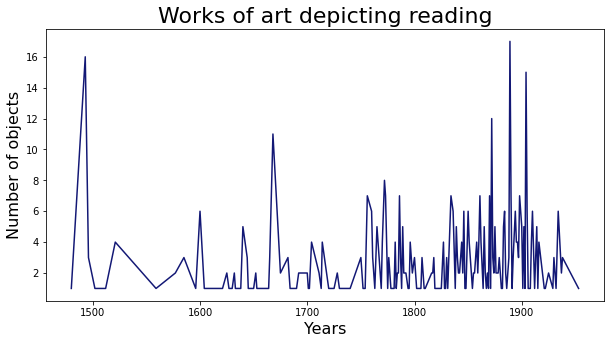

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure( figsize = ( 10,5 ) )

graph = sns.lineplot( x= dates_freq.keys() , y= dates_freq.values() , color = '#131875' )


graph.set_xlabel('Years' , size = 16 )
graph.set_ylabel('Number of objects' , size = 16 )
graph.set_title( 'Works of art depicting reading' , size = 22 )


plt.show()